In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import os
from scipy.signal import savgol_filter

pd.set_option('precision', 2)
np.set_printoptions(precision=2)

plt.rcParams['axes.facecolor'] = '0.95'

## Importing Data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        db_path = os.path.join(dirname, filename)

# connect to SQL database, create connection object to database
connection = sql.connect(db_path)
print("SQL database connected")

# show all table names in the database
table = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", connection)
print(table)

SQL database connected
      name
0  reviews
1  artists
2   genres
3   labels
4    years
5  content


In [3]:
reviews = pd.read_sql('SELECT * FROM reviews', connection)
genres = pd.read_sql('SELECT * FROM genres', connection)
connection.close()
print('SQL database connection closed')

SQL database connection closed


In [4]:
s = reviews.groupby('score')
# sum col denotes number of reviews w/ this score that were given bnm
info = s['best_new_music'].agg(['sum', 'count']).reset_index()
info

,score,sum,count
0,0.0,0,6
1,0.1,0,1
2,0.2,0,5
3,0.3,0,1
4,0.4,0,4
...,...,...,...
96,9.6,3,14
97,9.7,1,14
98,9.8,1,7
99,9.9,0,1


### Descriptive stats and Score Frequency

Average score: 7.005779372587397
Score std dev: 1.2936393340986625


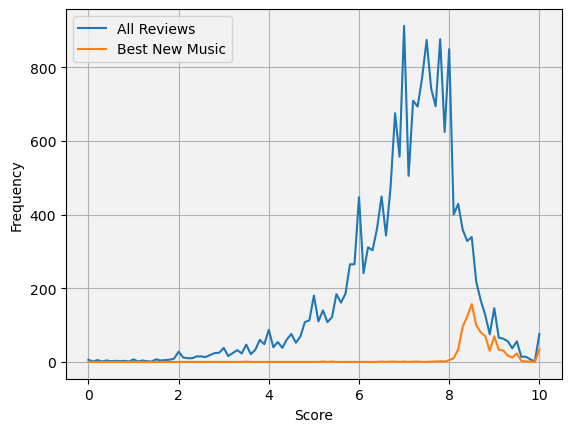

In [5]:
print('Average score: ' + str(np.mean(reviews['score'])))
print('Score std dev: ' + str(np.std(reviews['score'])))

plt.plot(info['score'], info['count'], label = 'All Reviews') 
plt.plot(info['score'], info['sum'], label = "Best New Music") 
plt.legend(loc = 'best')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

* A vast majority of the scores for albums in general are centered around 7, with the mass fn falling off drastically outside of the [5.7, 8.3] range (left-skewed)  
* For albums awarded best new music, scores tend to be higher, at around 8.5 (right-skewed)

## How do score distributions vary when grouped by genre?  
First, let's use SQL to query the database again and augment the score data with the genre of the reviewed album.

In [6]:
connection = sql.connect(db_path)
print('SQL database connected')

query = """
SELECT
    reviewid, score, genre
    FROM reviews
        JOIN genres
            USING (reviewid);
"""
genred_scores = pd.read_sql(query, connection)

connection.close()
print('SQL database connection closed')

genred_scores

SQL database connected
SQL database connection closed


,reviewid,score,genre
0,22703,9.3,electronic
1,22721,7.9,metal
2,22659,7.3,rock
3,22661,9.0,rock
4,22725,8.1,electronic
...,...,...,...
22685,5376,6.3,rock
22686,2413,7.2,experimental
22687,2413,7.2,metal
22688,2413,7.2,rock


Now we'll plot the score data for each genre, with genres sorted according to # of reviews. We'll sort the plotted genres by descending number of reviews, so the leftmost box and whisker will represent score distribution of rock, Pitchfork's most-reviewed genre.

Text(0.5, 1.0, 'Review Scores by Genre')

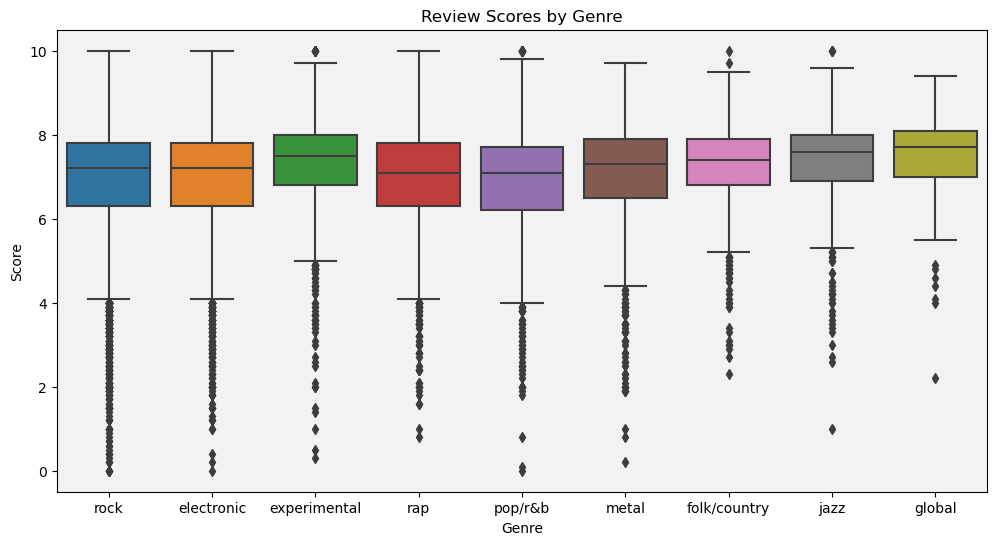

In [7]:
g_counts = genred_scores['genre'].value_counts()
g_order = g_counts.index

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=genred_scores, x="genre", y="score", order=g_order, ax=ax)
plt.xlabel('Genre')
plt.ylabel('Score')
plt.title('Review Scores by Genre')

The median scores for all of the genres are reasonably close together, and distances between quartiles also appear similar. It is interesting to note that, in general, there is a greater score range in the lower quartile than in the upper; this could be partially explained by the fact that the median is itself in the higher end of the 0-10 score scale.

## How do scoring averages vary with review author?  
No need to augment the reviews data here, since the table already contains reviewing author as one of its columns.  
Since the number of authors is ostensibly quite high (we'll see how many different authors have contributed to Pitchfork reviews from 1999 to 2017 below), we'll plot them according to number of reviews written and average score given, labelling notable data points with the author in question's name.

In [8]:
a_counts = reviews['author'].value_counts()
a_order = a_counts.index
print(str(len(a_counts)) + ' authors have contributed to Pitchfork reviews.')

432 authors have contributed to Pitchfork reviews.


In [9]:
a = reviews.groupby('author')
a_metrics = a.score.agg(('mean', 'count'))

# Drop authors with only a low number of reviews - let's say < 20
a_metrics = a_metrics.loc[a_metrics['count'] >= 20]

# Get names of notable authors: min/max avg review score, max number of reviews
names = [
    a_metrics['mean'].idxmin(),
    a_metrics['mean'].idxmax(),
    a_metrics['count'].idxmax(),    
]

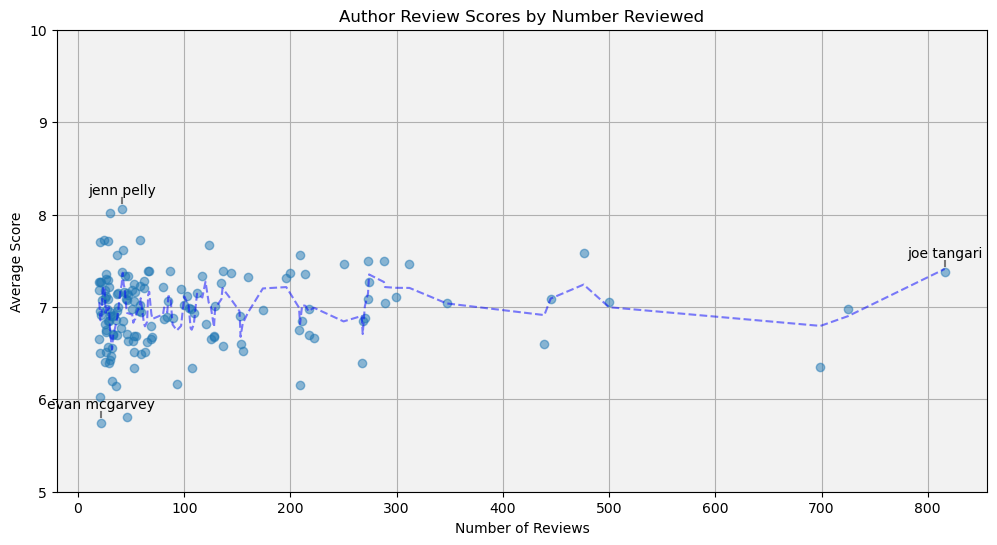

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

# plot all authors
ax.plot(a_metrics['count'], a_metrics['mean'], 'o', alpha = 0.5)

# plot avg score for each count
avg = a_metrics.groupby('count')['mean'].mean().reset_index()
avg['mean'] = savgol_filter(avg['mean'], 3, 1)
ax.plot(avg['count'], avg['mean'],'b--', alpha = 0.5)

# label the notable authors
for name in names:
    x, y = a_metrics.loc[name, 'count'], a_metrics.loc[name, 'mean']
    ax.plot([x,x], [y+0.07,y+0.12], '-', c='black', alpha = 0.5)
    ax.text(x, y+0.2, name, ha = 'center', va = 'center')

plt.xlabel('Number of Reviews')
plt.ylabel('Average Score')
plt.title('Author Review Scores by Number Reviewed')
plt.ylim([5, 10])
plt.grid()
    